# Import Libraries

In [1]:
#for data processing or visualization
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import random
import math

#load data 
import os 

#for deep learning module
import torch 
from torch import nn 
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets
from torchvision import transforms

# Configurations

In [2]:
#define the loading list of data
ROOT = '/Users/r/Desktop/git_repository/machine_learning/dataset/UNET-Dataset/'

img_path = ROOT + 'CameraRGB/'
msk_path = ROOT + 'CameraMask/'

img_list = os.listdir(img_path) 
msk_list = os.listdir(msk_path)

img_list = [img_path + i for i in img_list]
msk_list = [msk_path + i for i in msk_list]

BATCH_SIZE = 32

LR = 1e-3

EPOCH = 300

DEVICE = 'mps'

# Have a look on the raw image and its mask

Text(0.5, 1.0, 'segmentation mask')

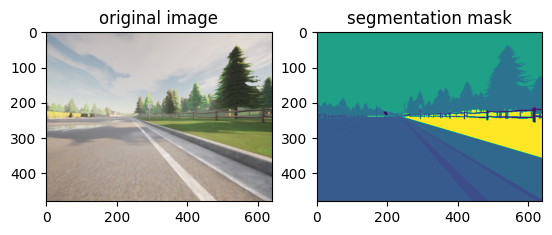

In [3]:
N = 0
img = plt.imread(img_list[N])
img = img[:,:,0:3]
msk = plt.imread(msk_list[N])

fig, ax = plt.subplots(1,2)
ax[0].imshow(img)
ax[0].set_title('original image')
ax[1].imshow(msk[:,:,0])
ax[1].set_title('segmentation mask')

In [4]:
train_augs = transforms.Compose([
    transforms.ToTensor()
])

def load_data(img_list, msk_list, new_h, new_w, augs):
    data_list = [None]*len(img_list)
    for i in range(len(img_list)):
        img = plt.imread(img_list[i])
        img = img[:,:,0:3]
        msk = plt.imread(msk_list[i])
        msk = msk[:, :, 0]*255
        img = cv2.resize(img, (new_w, new_h))
        msk = cv2.resize(msk, (new_w, new_h))
        
        img = augs(img)
        #msk = torch.tensor(msk, dtype = torch.float)
        msk = torch.tensor(msk)
        #msk = msk.view((1, msk.shape[0], msk.shape[1]))
        data_list[i] = (img, msk)
    
    return data_list

data_list = load_data(img_list, msk_list, 96, 128, train_augs)

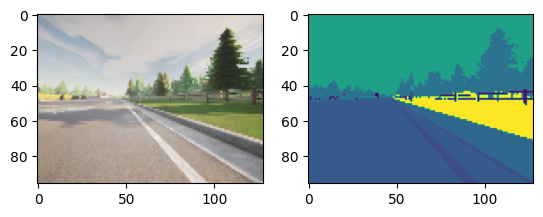

In [5]:
fig, ax = plt.subplots(1, 2)

img, msk = data_list[0]

ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(msk)

# Split into Training, Validation and Testing Data

In [6]:
def split_ids(data, train=.7, valid=0.1, test=0.2, seed = 0):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test  (float): test split size (between 0 - 1)
    Outputs:
        train_set: list of training data
        valid_set: list of validation data
        test_set: list of testing data
    """
    
    list_copy = list(range(0, len(data)))
    random.Random(seed).shuffle(list_copy)
    
    #obtain the size of training, validation and testing data
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    test_size = len(list_copy) - train_size - valid_size
    
    train_set = [None]*train_size
    if train + valid == 1.0:
        valid_size += test_size
        valid_set = [None]*valid_size
        test_set  = None
        test_size = 0
    else:
        valid_set = [None]*valid_size
        test_set  = [None]*test_size
    
    #split the data into training, validation and testing dataset
    idx = 0
    for cnt, i in enumerate(list_copy):
        
        if cnt == train_size or cnt == train_size + valid_size:
            idx = 0
            
        if cnt < train_size:
            train_set[idx]= (data[i][0], 
                             data[i][1])
        elif cnt >= train_size and cnt < train_size + valid_size:
            valid_set[idx]= (data[i][0], 
                             data[i][1])
        else:
            test_set[idx] = (data[i][0], 
                             data[i][1])
        idx += 1
        
    return train_set, valid_set, test_set

In [7]:
train_data, valid_data, test_data = split_ids(data_list, train = 0.6, valid = 0.2, test = 0.2)

#check if the training and validation dataset are in correct proportion
N_data  = len(data_list)
N_train = len(train_data)
N_valid = len(valid_data)
N_test  = len(test_data)

print(f'Total number of data: {N_data}')
print(f'Total number of training data: {N_train} ({N_train/N_data :.2f})')
print(f'Total number of validation data: {N_valid} ({N_valid/N_data :.2f})')
print(f'Total number of testing data: {N_test} ({N_test/N_data :.2f})')

Total number of data: 1060
Total number of training data: 636 (0.60)
Total number of validation data: 212 (0.20)
Total number of testing data: 212 (0.20)


# Get mini-batch of Training Data

In [8]:
trainloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = False)
testloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)

images shape:  torch.Size([32, 3, 96, 128])
masks shape:  torch.Size([32, 96, 128])


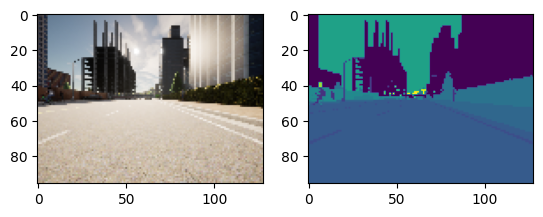

In [9]:
train_iter = iter(trainloader)
images, masks = next(train_iter)

print('images shape: ', images.shape)
print('masks shape: ', masks.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[0].permute(1,2,0))
ax[1].imshow(masks[0])

# Construct Encoder Blocks

In [10]:
class DownConvBlock(nn.Module):
    def __init__(self, in_c, k_size = (3, 3), p_size = 1):
        super(DownConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels  = in_c, 
                          out_channels = in_c*2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.conv2 = nn.Conv2d(in_channels  = in_c*2, 
                          out_channels = in_c*2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.activation = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.max_pool(x)
        
        return x
        

# Construct Decoder Blocks

In [11]:
class UpConvBlock(nn.Module):
    def __init__(self, in_c, k_size = (3, 3), p_size = 1):
        super(UpConvBlock, self).__init__()
        

        self.conv1 = nn.Conv2d(in_channels  = in_c, 
                          out_channels = in_c//2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.conv2 = nn.Conv2d(in_channels  = in_c, 
                          out_channels = in_c//2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.conv3 = nn.Conv2d(in_channels  = in_c//2, 
                          out_channels = in_c//2,
                          kernel_size  = k_size,
                          padding = p_size)
        self.activation = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor = 2, 
                                    mode = 'bilinear',
                                    align_corners=True)
        
    def forward(self, x, skip_x):
        
        x = self.upsample(x)
        x = self.conv1(x)
        x = torch.cat([x, skip_x], axis = 1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        
        return x
        

# Construct Feature Maps

In [12]:
class FeatureMap(nn.Module):
    def __init__(self, in_c, out_c):
        super(FeatureMap, self).__init__()
        self.conv = nn.Conv2d(in_channels = in_c, 
                              out_channels = out_c, 
                              kernel_size = (1, 1))
    
    def forward(self, x):
        x = self.conv(x)
        return x

# Construct U-Net

In [13]:
class UNet(nn.Module):
    def __init__(self, in_c, out_c, h_c):
        super(UNet, self).__init__()
        self.upfeature = FeatureMap(in_c, h_c)
        self.contract1 = DownConvBlock(h_c)
        self.contract2 = DownConvBlock(h_c*2)
        self.contract3 = DownConvBlock(h_c*4)
        self.contract4 = DownConvBlock(h_c*8) 
        self.expand1 = UpConvBlock(h_c*16)
        self.expand2 = UpConvBlock(h_c*8)
        self.expand3 = UpConvBlock(h_c*4)
        self.expand4 = UpConvBlock(h_c*2)
        self.downfeature = FeatureMap(h_c, out_c)
        
    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3) #bridge between encoder and decoder
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        out = self.downfeature(x8)
        
        return out

In [14]:
model = UNet(3, 23, 16)
summary(model, (3, 96, 128))
model.to(DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 96, 128]              64
        FeatureMap-2          [-1, 16, 96, 128]               0
            Conv2d-3          [-1, 32, 96, 128]           4,640
              ReLU-4          [-1, 32, 96, 128]               0
            Conv2d-5          [-1, 32, 96, 128]           9,248
              ReLU-6          [-1, 32, 96, 128]               0
         MaxPool2d-7           [-1, 32, 48, 64]               0
     DownConvBlock-8           [-1, 32, 48, 64]               0
            Conv2d-9           [-1, 64, 48, 64]          18,496
             ReLU-10           [-1, 64, 48, 64]               0
           Conv2d-11           [-1, 64, 48, 64]          36,928
             ReLU-12           [-1, 64, 48, 64]               0
        MaxPool2d-13           [-1, 64, 24, 32]               0
    DownConvBlock-14           [-1, 64,

UNet(
  (upfeature): FeatureMap(
    (conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  )
  (contract1): DownConvBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract2): DownConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (contract3): DownConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation): ReLU()
    (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padd

In [15]:
#define training loop
def train_fcn(dataloader, model, criterion, opt):
    '''
    Args:
        dataloader: mini-batch of training data
        model     : convolutional neural network
        criterion : loss function for optimization
        opt       : optimizer for updating parameters of neural network
    Outputs:
        avg_loss  : average loss of one training epoch
    '''
    
    
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0

    for (images, labels) in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        opt.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.long())
        preds_max = torch.argmax(preds, dim = 1, keepdim = True)
        preds_max = preds_max[:,0,:,:]
        
        loss.backward()
        opt.step()
        
        total_loss += loss.item()
        total_acc += torch.sum(preds_max == labels)/(96*128*BATCH_SIZE)
        
        n += 1
    avg_loss = total_loss/n
    avg_acc = total_acc/n
    return avg_loss, avg_acc 

In [16]:
#define training loop
def eval_fcn(dataloader, model, criterion):
    '''
    Args:
        dataloader: mini-batch of training data
        model     : convolutional neural network
        criterion : loss function for optimization
    Outputs:
        avg_loss  : average loss of one evaluation epoch
    '''
    
    
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for (images, labels) in dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)
        loss = criterion(preds, labels.long())
        preds_max = torch.argmax(preds, dim = 1, keepdim = True)
        preds_max = preds_max[:,0,:,:]
                
        total_loss += loss.item()
        total_acc += torch.sum(preds_max == labels)/(96*128*BATCH_SIZE)
        
        n += 1
        
    avg_loss = total_loss/n
    avg_acc = total_acc/n
    
    return avg_loss, avg_acc 

In [17]:
#define the optimizer
opt = torch.optim.Adam(model.parameters(), lr = LR)
#define the loss
criterion = torch.nn.CrossEntropyLoss()

#start training 
best_valid_loss = np.Inf
train_loss_list = [None]*EPOCH
valid_loss_list = [None]*EPOCH


for i in range(EPOCH):
    train_loss_list[i], train_acc = train_fcn(trainloader, model, criterion, opt)
    valid_loss_list[i], eval_acc  = eval_fcn(validloader, model, criterion)
    
    #save better model with lower validation loss
    if valid_loss_list[i] < best_valid_loss:
        best_valid_loss =  valid_loss_list[i]
        torch.save(model.state_dict(), 'best_weights.pt')
        print(f'epoch {i + 1} Found and saved model!')
        
    print(f'epoch {i + 1} training loss: {train_loss_list[i] :.2f} training accuracy: {train_acc*100 :.2f}%')
    print(f'epoch {i + 1} evaluation loss: {valid_loss_list[i] :.2f} evaluation accuracy: {eval_acc*100 :.2f}%')


Found and saved model!
epoch 1 training loss: 2.97 training accuracy: 18.94%
epoch 1 evaluation loss: 2.38 training accuracy: 31.91%
Found and saved model!
epoch 2 training loss: 1.84 training accuracy: 43.19%
epoch 2 evaluation loss: 1.57 training accuracy: 43.33%
epoch 3 training loss: 1.63 training accuracy: 43.87%
epoch 3 evaluation loss: 1.61 training accuracy: 33.04%
Found and saved model!
epoch 4 training loss: 1.58 training accuracy: 41.46%
epoch 4 evaluation loss: 1.48 training accuracy: 44.27%
Found and saved model!
epoch 5 training loss: 1.47 training accuracy: 51.76%
epoch 5 evaluation loss: 1.41 training accuracy: 56.89%
epoch 6 training loss: 1.38 training accuracy: 57.61%
epoch 6 evaluation loss: 1.50 training accuracy: 45.82%
Found and saved model!
epoch 7 training loss: 1.35 training accuracy: 57.36%
epoch 7 evaluation loss: 1.15 training accuracy: 66.22%
Found and saved model!
epoch 8 training loss: 1.00 training accuracy: 72.97%
epoch 8 evaluation loss: 0.77 training

epoch 65 training loss: 0.17 training accuracy: 94.08%
epoch 65 evaluation loss: 0.19 training accuracy: 89.25%
Found and saved model!
epoch 66 training loss: 0.17 training accuracy: 94.09%
epoch 66 evaluation loss: 0.18 training accuracy: 89.32%
epoch 67 training loss: 0.18 training accuracy: 93.92%
epoch 67 evaluation loss: 0.18 training accuracy: 89.15%
Found and saved model!
epoch 68 training loss: 0.17 training accuracy: 94.03%
epoch 68 evaluation loss: 0.18 training accuracy: 89.54%
Found and saved model!
epoch 69 training loss: 0.17 training accuracy: 94.29%
epoch 69 evaluation loss: 0.18 training accuracy: 89.54%
Found and saved model!
epoch 70 training loss: 0.16 training accuracy: 94.29%
epoch 70 evaluation loss: 0.17 training accuracy: 89.65%
epoch 71 training loss: 0.16 training accuracy: 94.36%
epoch 71 evaluation loss: 0.17 training accuracy: 89.66%
Found and saved model!
epoch 72 training loss: 0.16 training accuracy: 94.51%
epoch 72 evaluation loss: 0.17 training accura

Found and saved model!
epoch 133 training loss: 0.10 training accuracy: 96.00%
epoch 133 evaluation loss: 0.12 training accuracy: 91.13%
epoch 134 training loss: 0.10 training accuracy: 96.11%
epoch 134 evaluation loss: 0.12 training accuracy: 91.15%
Found and saved model!
epoch 135 training loss: 0.10 training accuracy: 96.15%
epoch 135 evaluation loss: 0.12 training accuracy: 91.23%
epoch 136 training loss: 0.10 training accuracy: 96.07%
epoch 136 evaluation loss: 0.12 training accuracy: 91.15%
epoch 137 training loss: 0.10 training accuracy: 96.06%
epoch 137 evaluation loss: 0.12 training accuracy: 91.14%
epoch 138 training loss: 0.10 training accuracy: 96.15%
epoch 138 evaluation loss: 0.12 training accuracy: 91.04%
Found and saved model!
epoch 139 training loss: 0.10 training accuracy: 96.13%
epoch 139 evaluation loss: 0.12 training accuracy: 91.23%
epoch 140 training loss: 0.10 training accuracy: 96.14%
epoch 140 evaluation loss: 0.12 training accuracy: 91.10%
epoch 141 training 

# Plot History of Training and Validation Loss 

Text(0, 0.5, 'Loss')

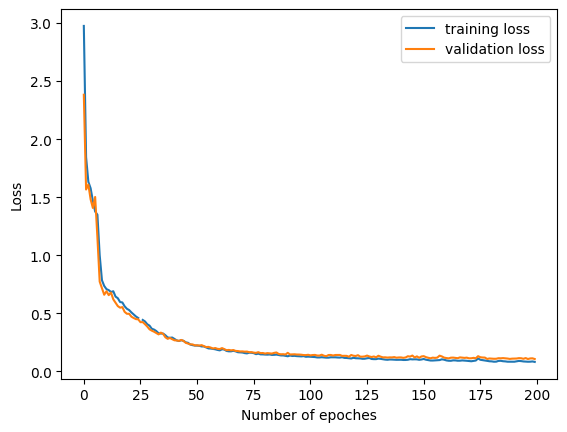

In [19]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Number of epoches')
plt.ylabel('Loss')

# Have a look on the Testing Result

/var/folders/vg/qjx94k1s147g4n3ybsntyyd80000gn/T/ipykernel_24360/237124756.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize = (20, 20))


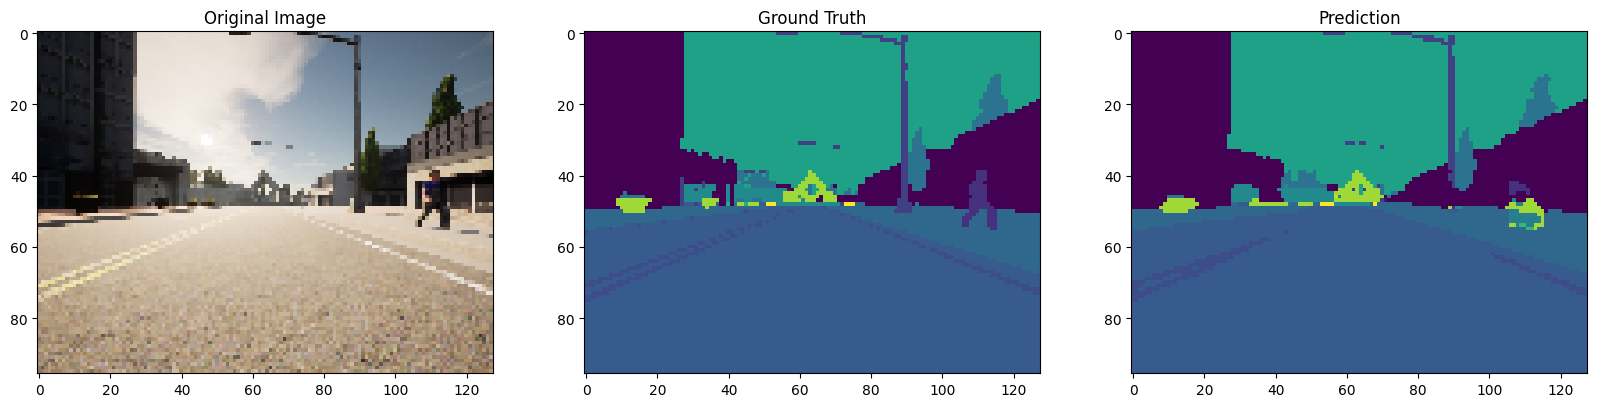

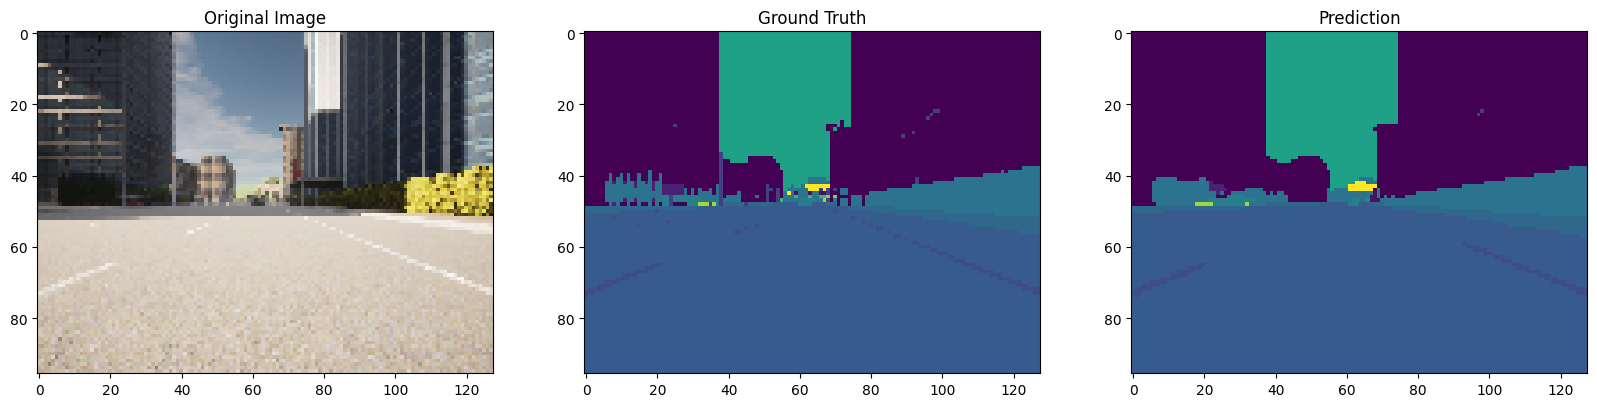

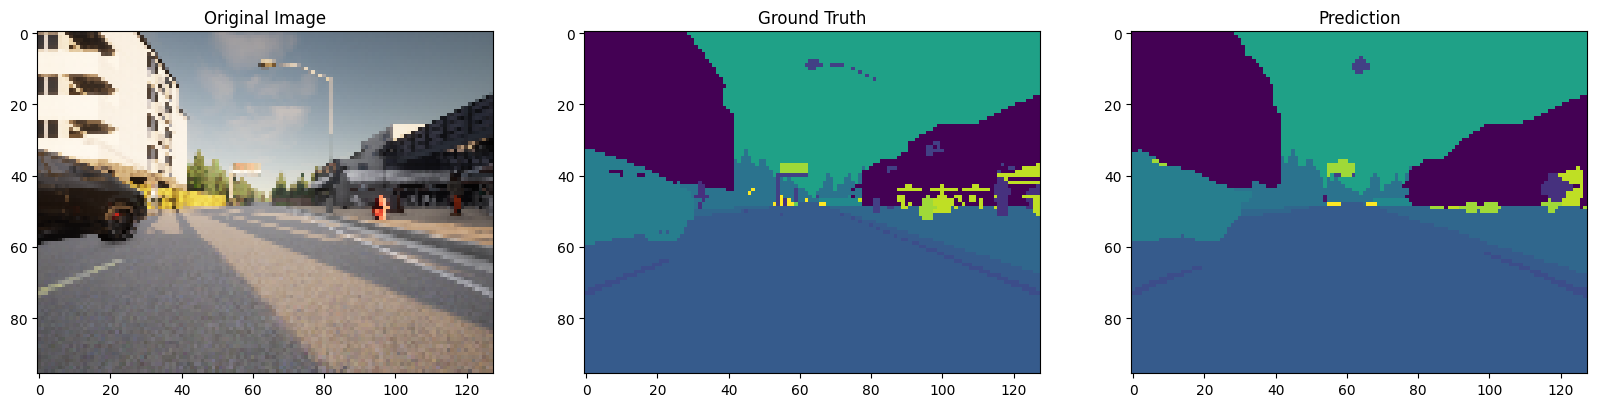

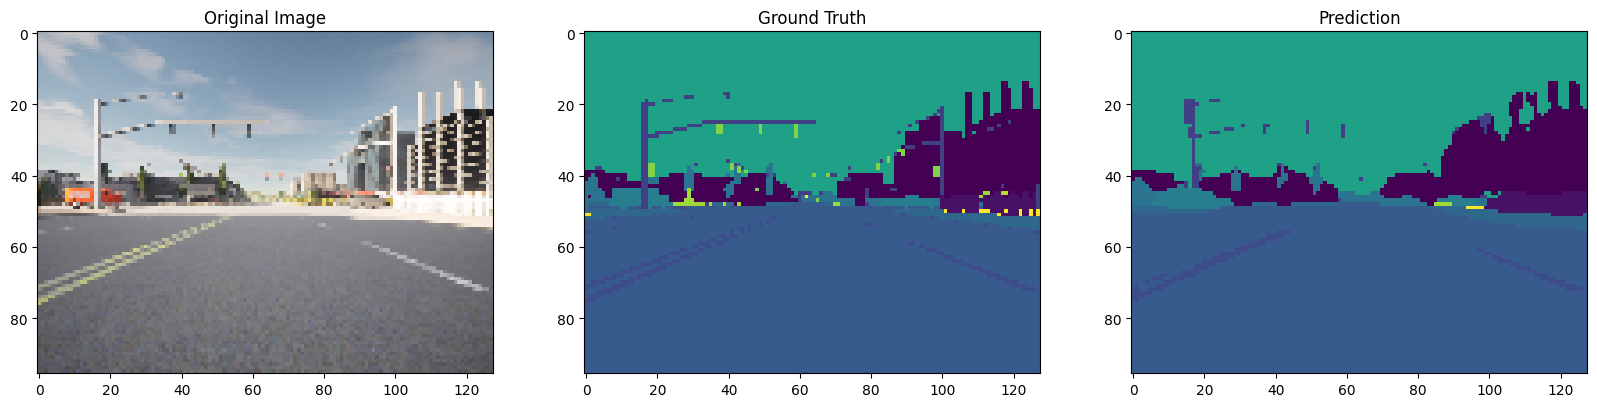

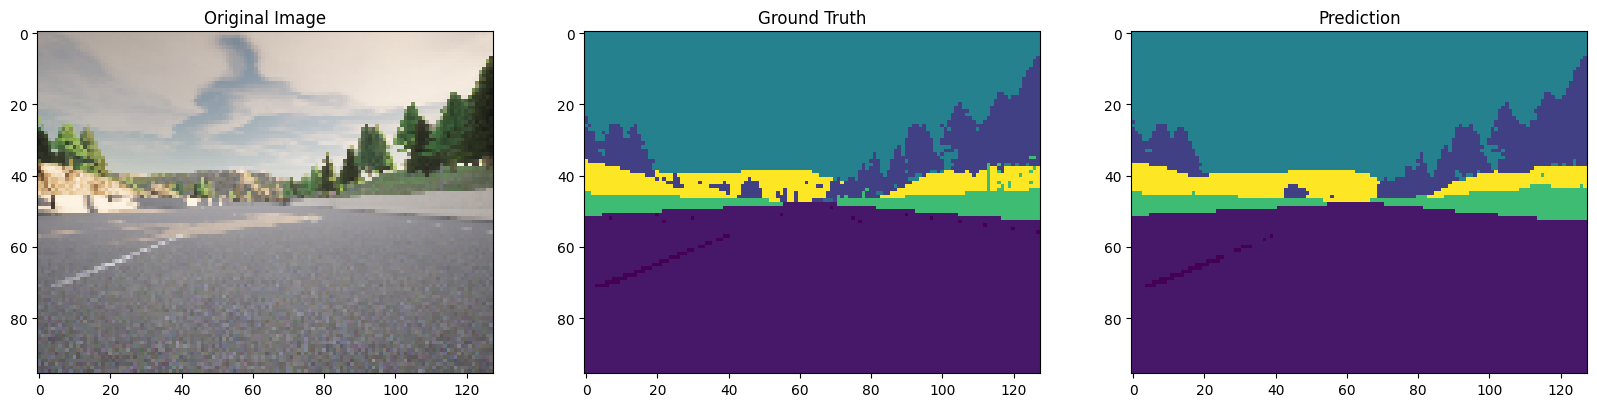

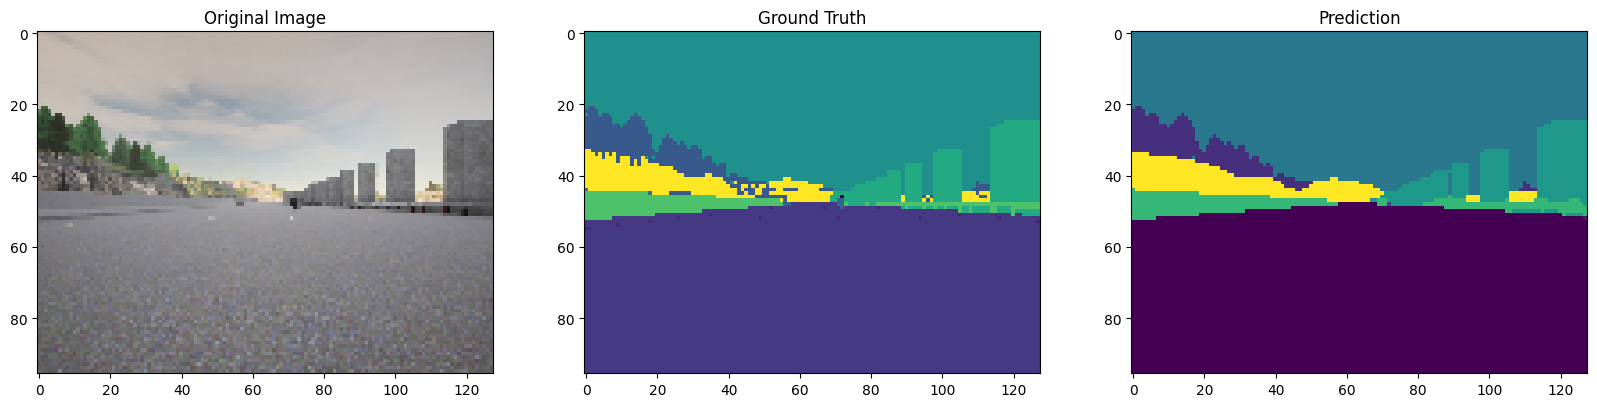

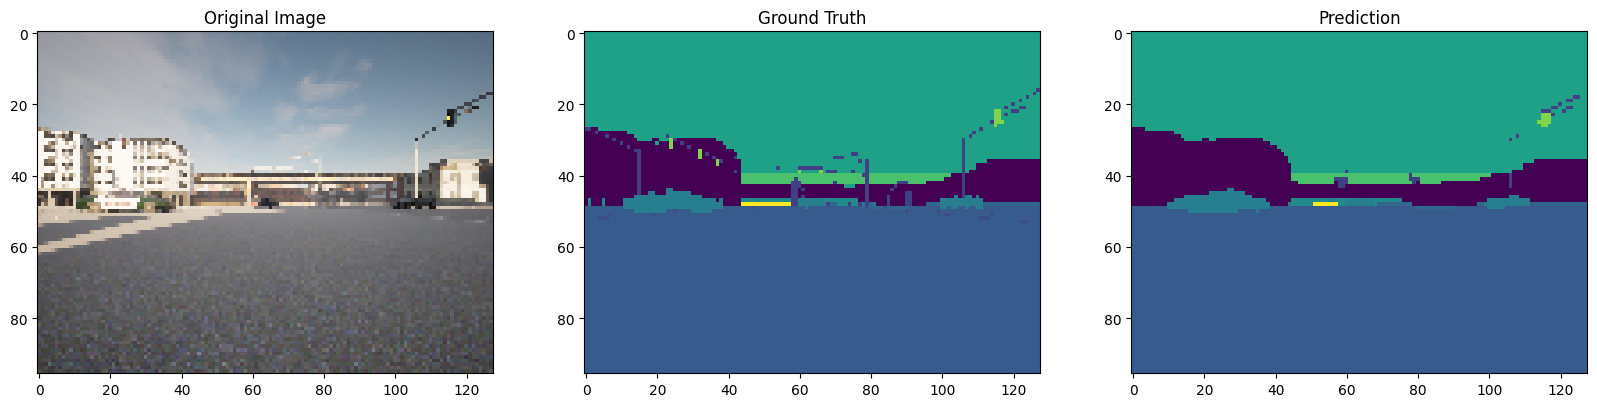

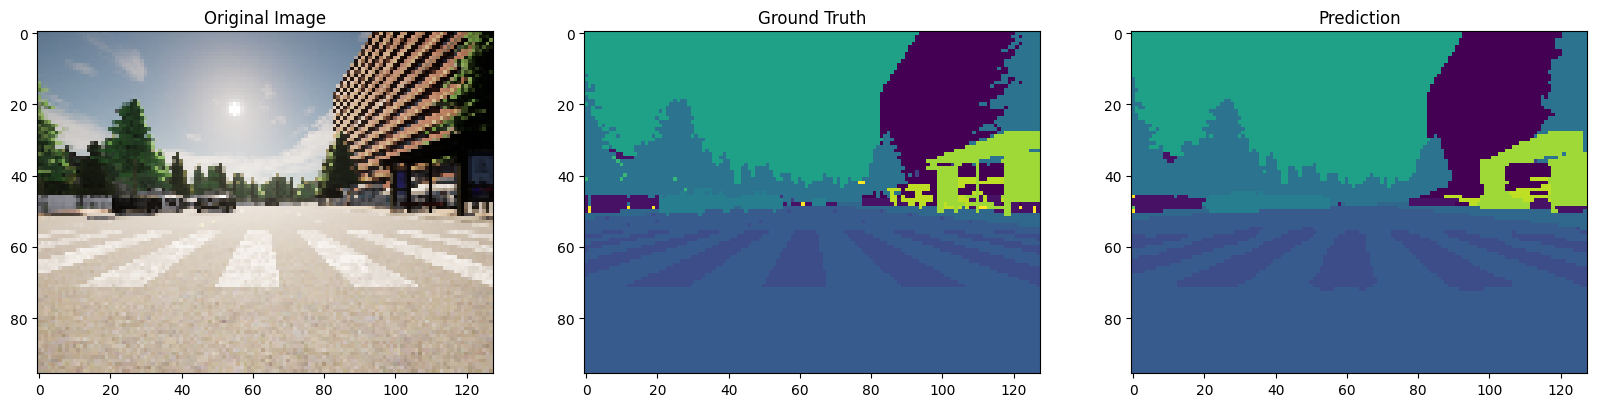

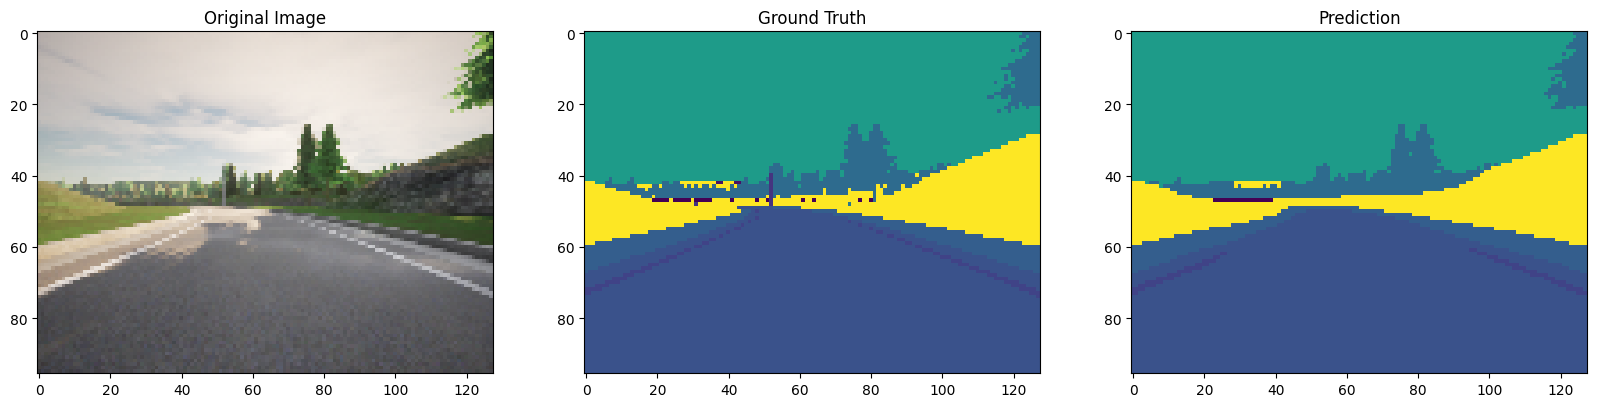

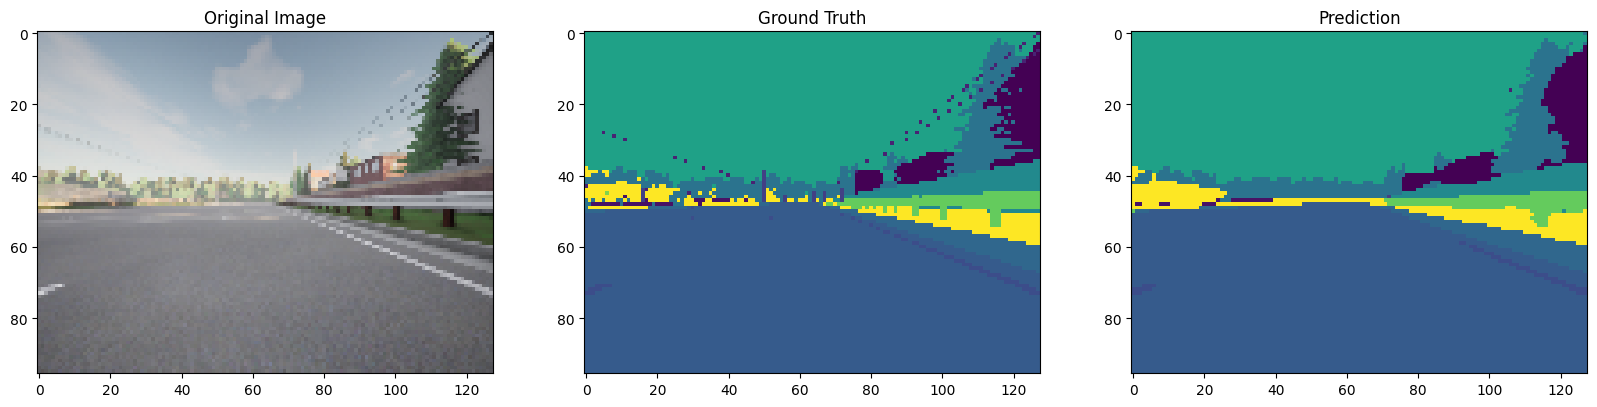

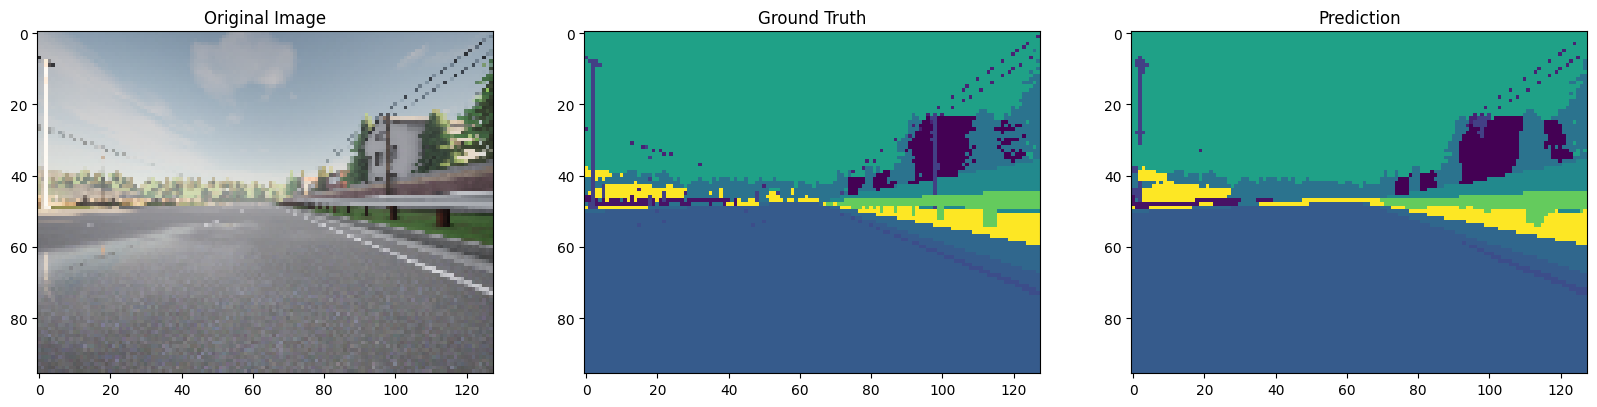

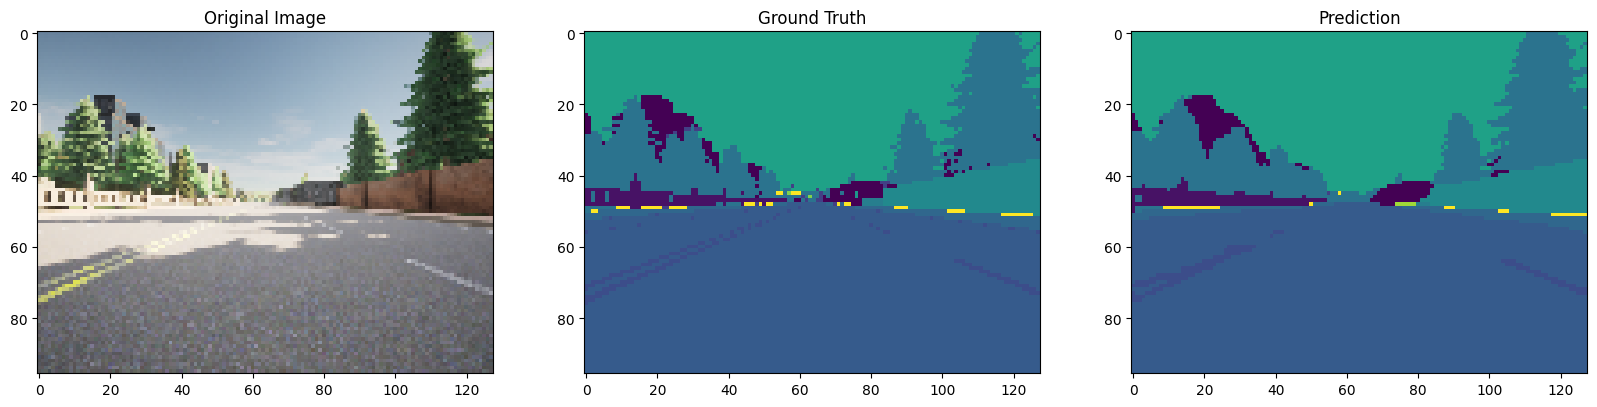

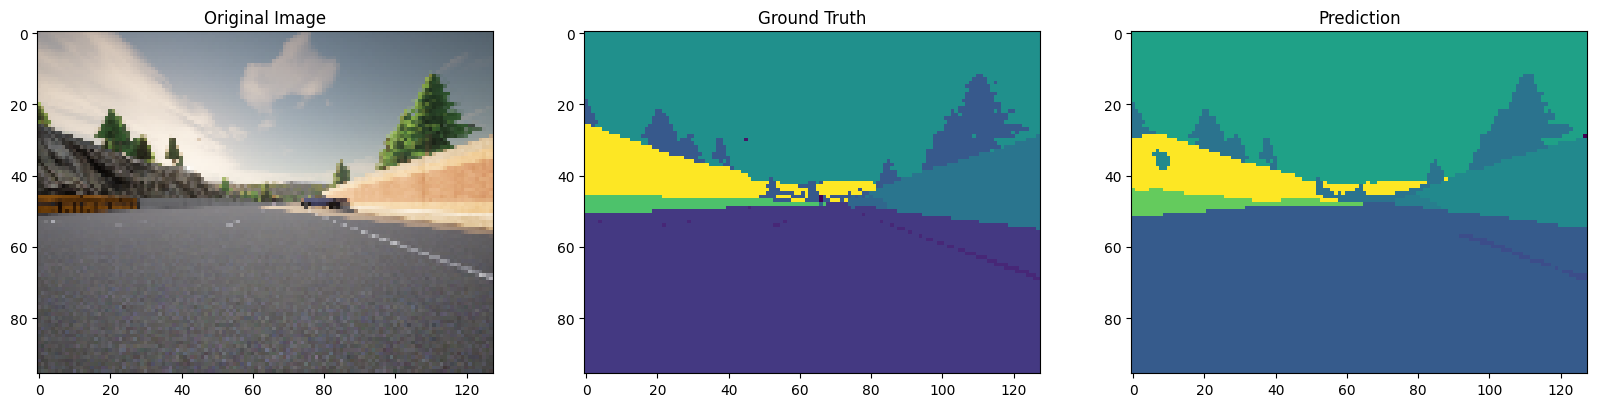

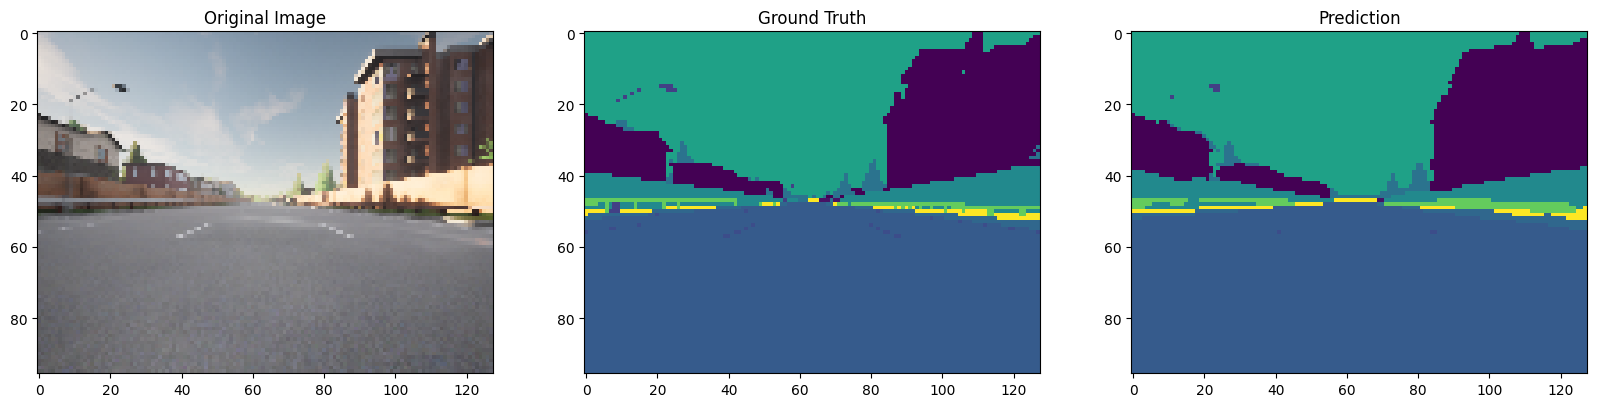

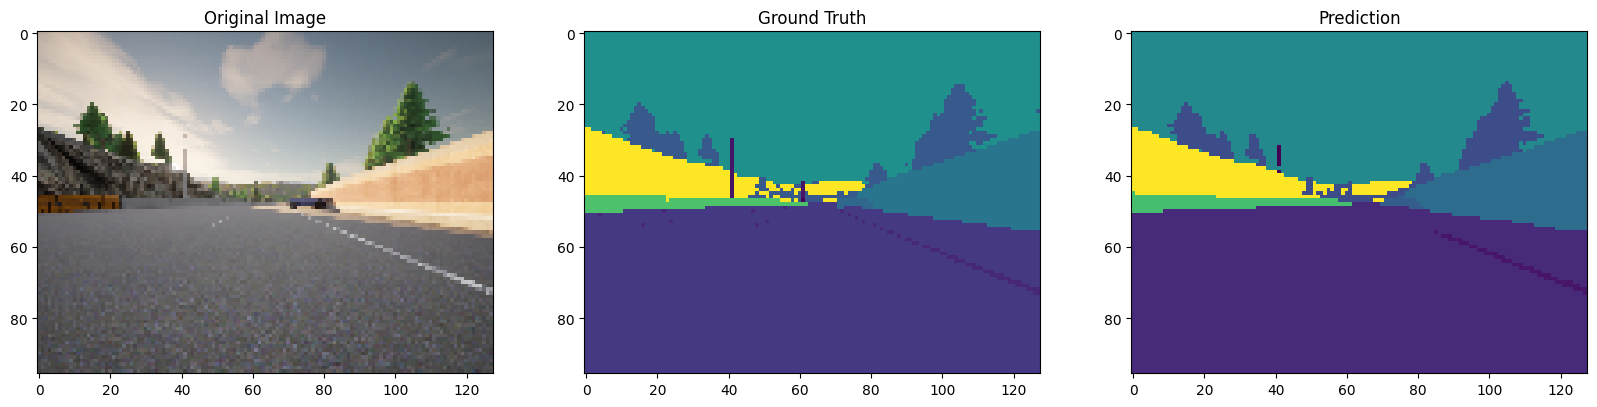

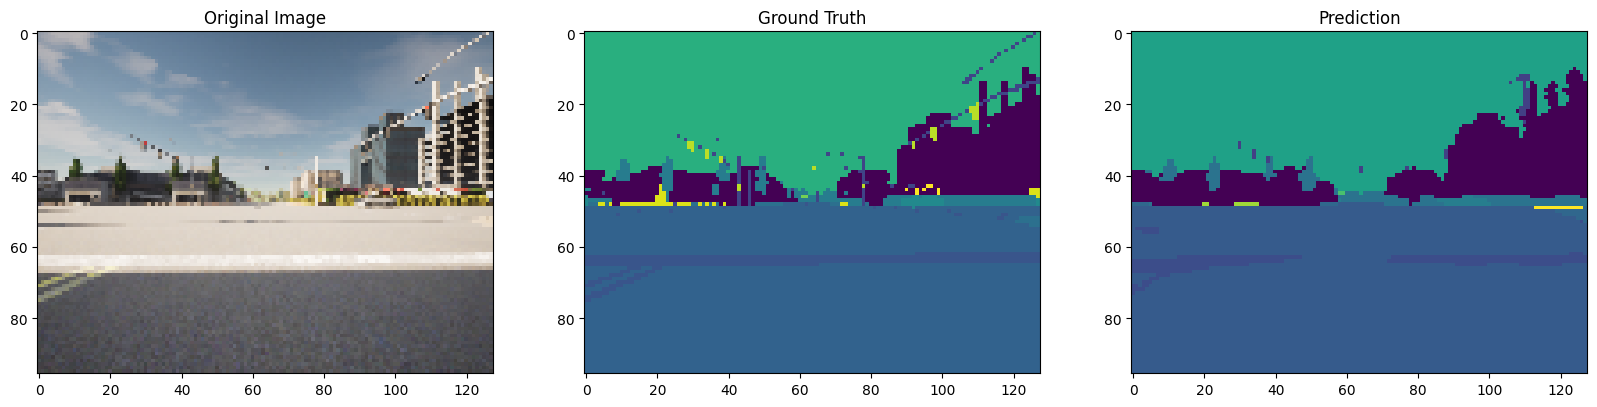

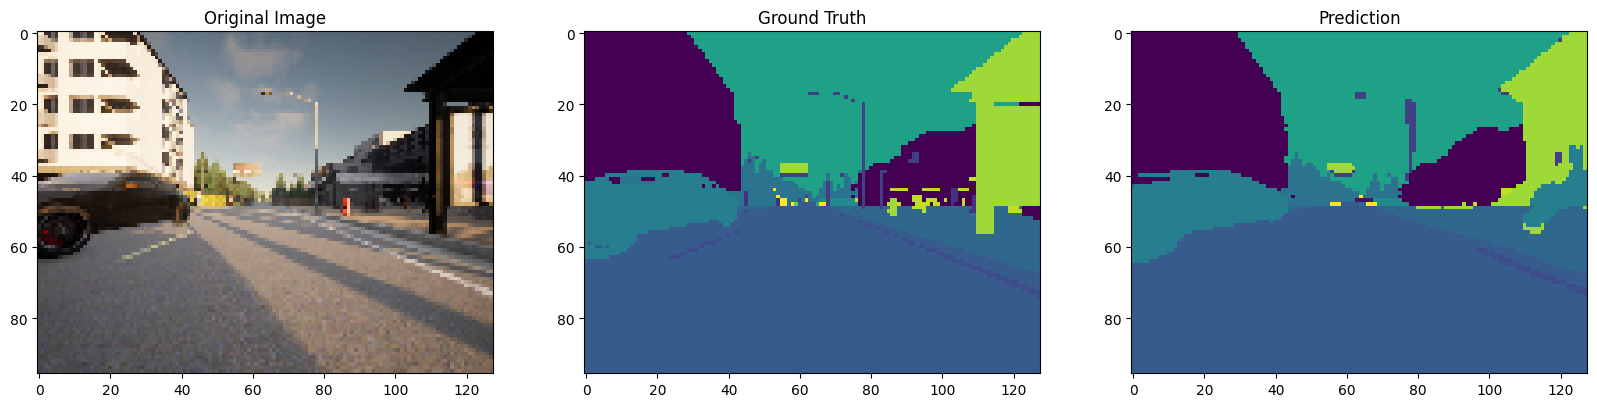

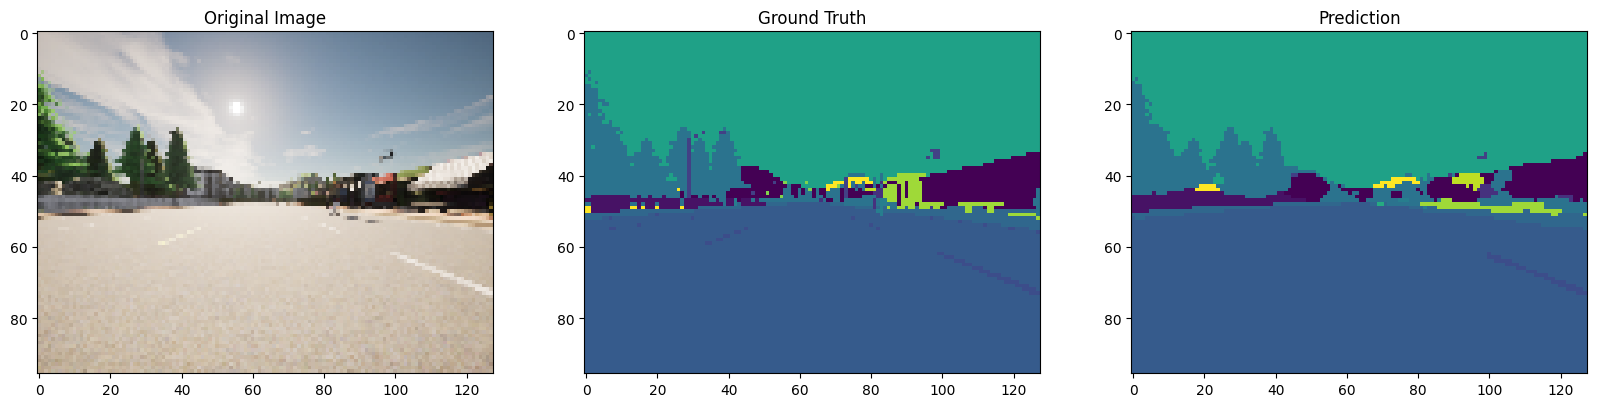

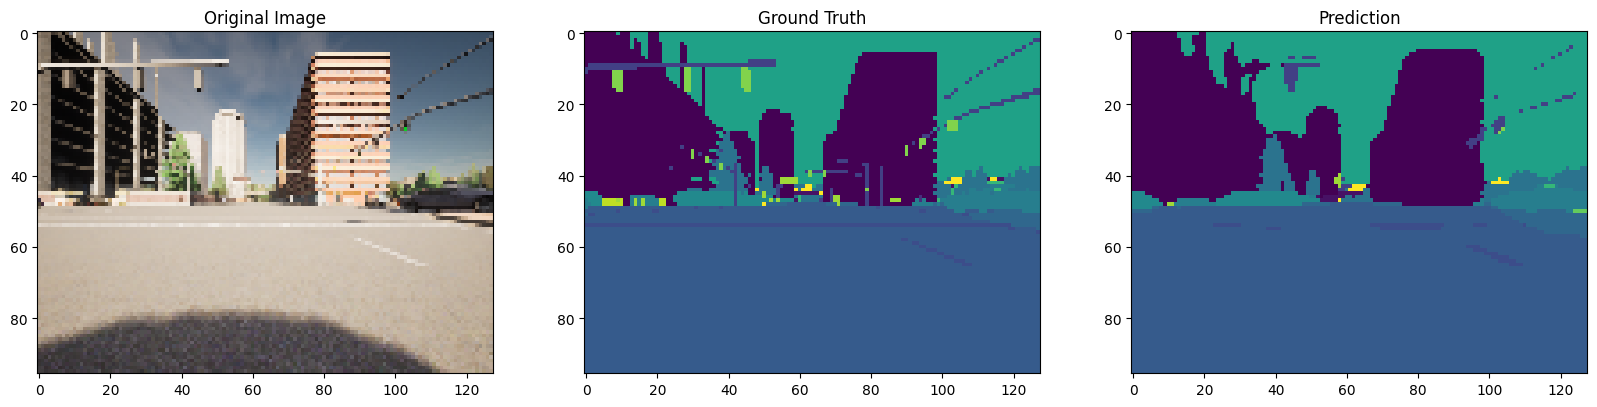

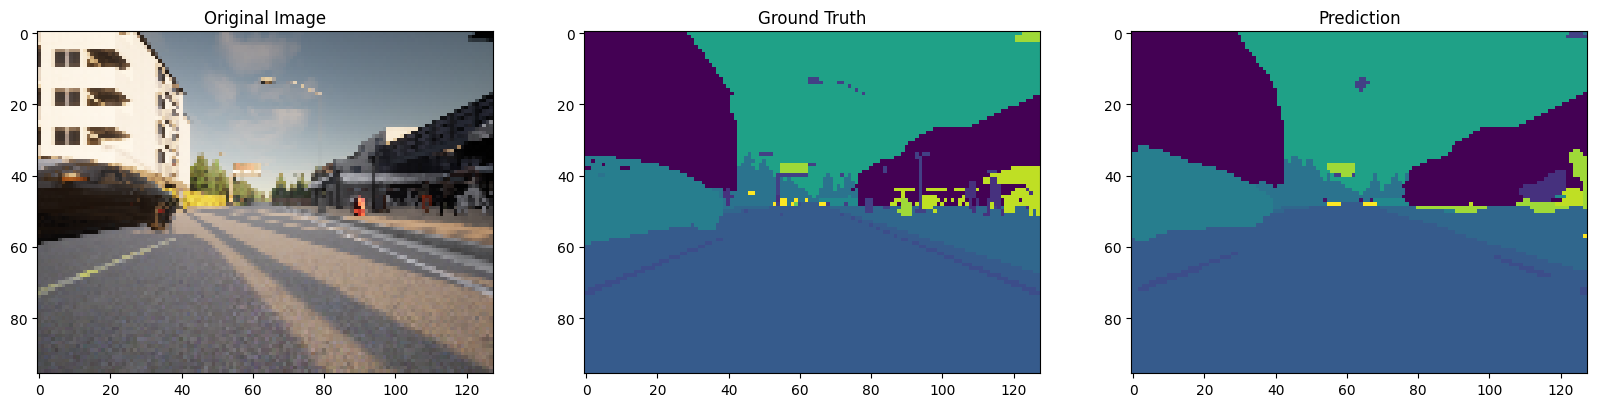

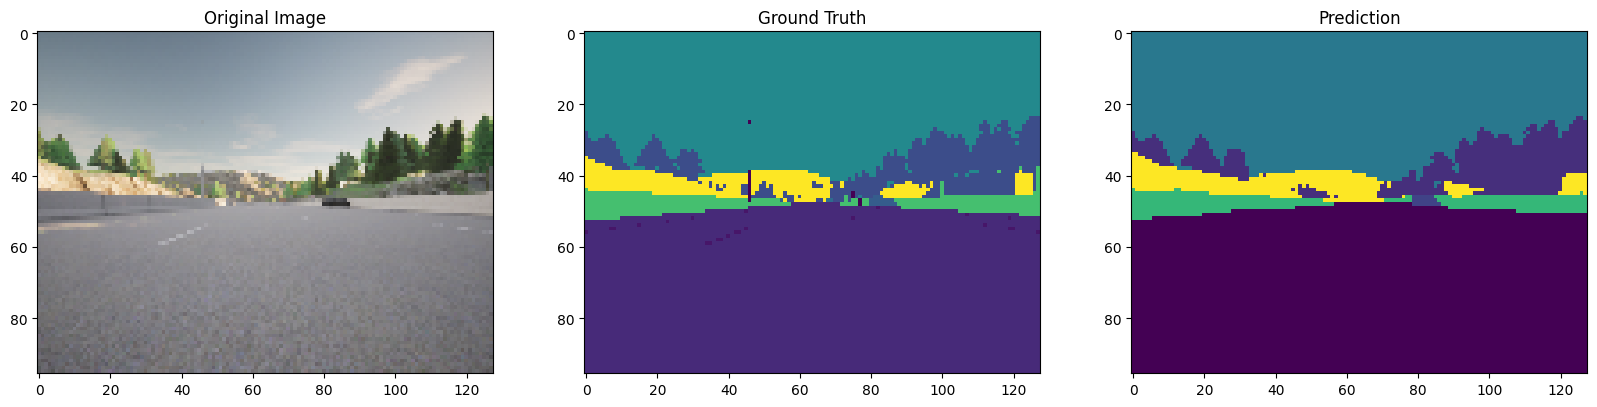

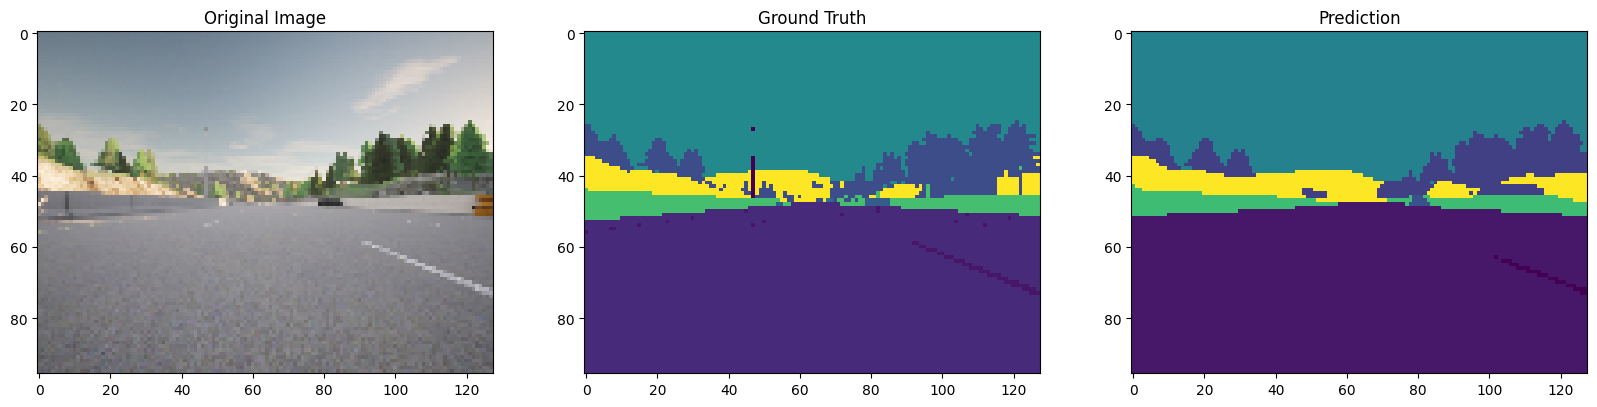

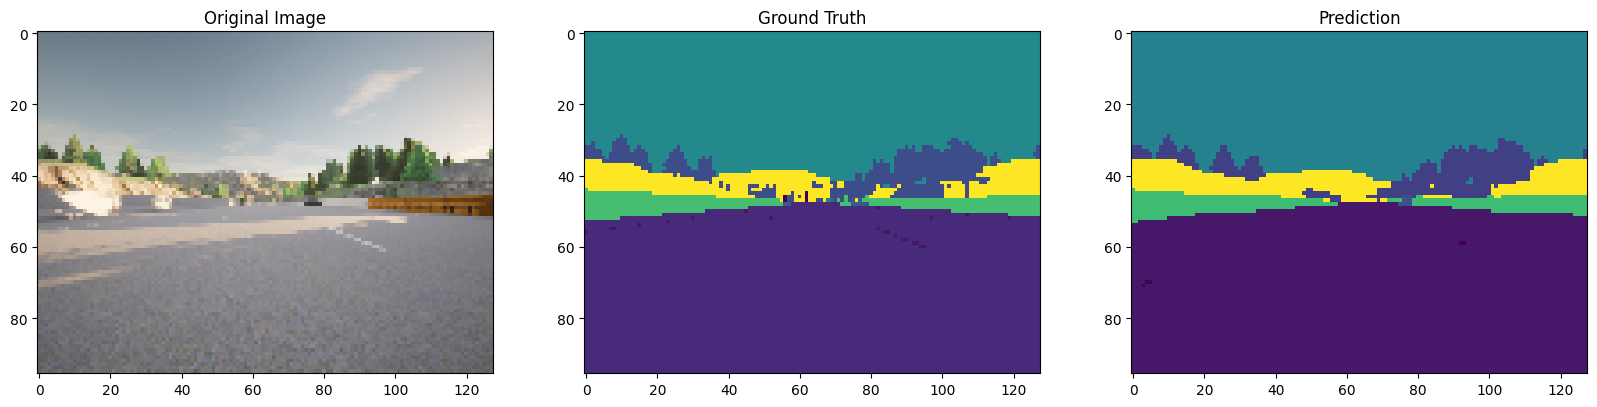

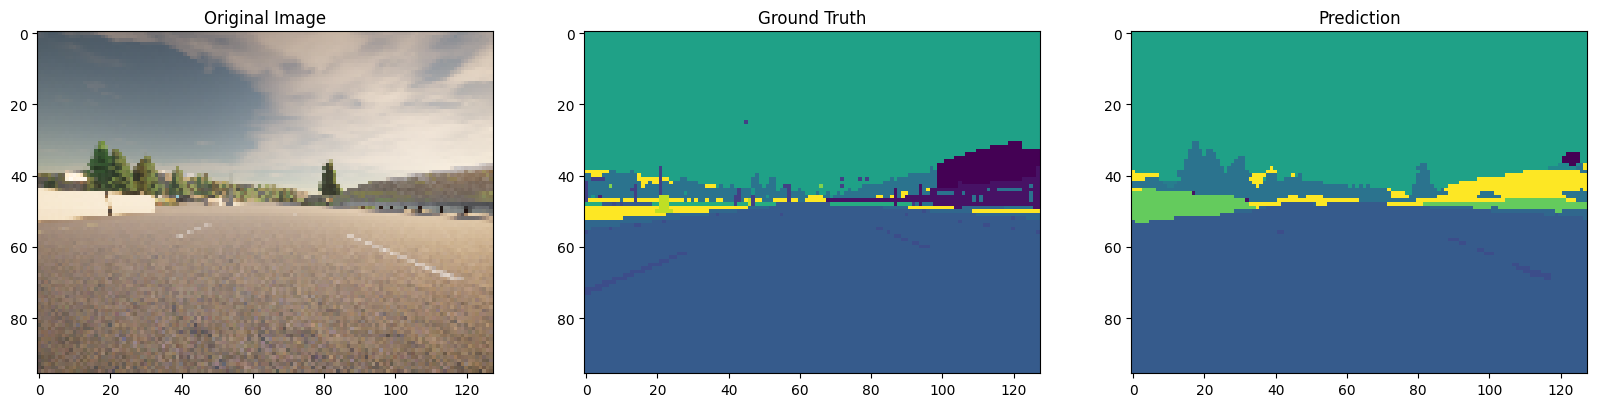

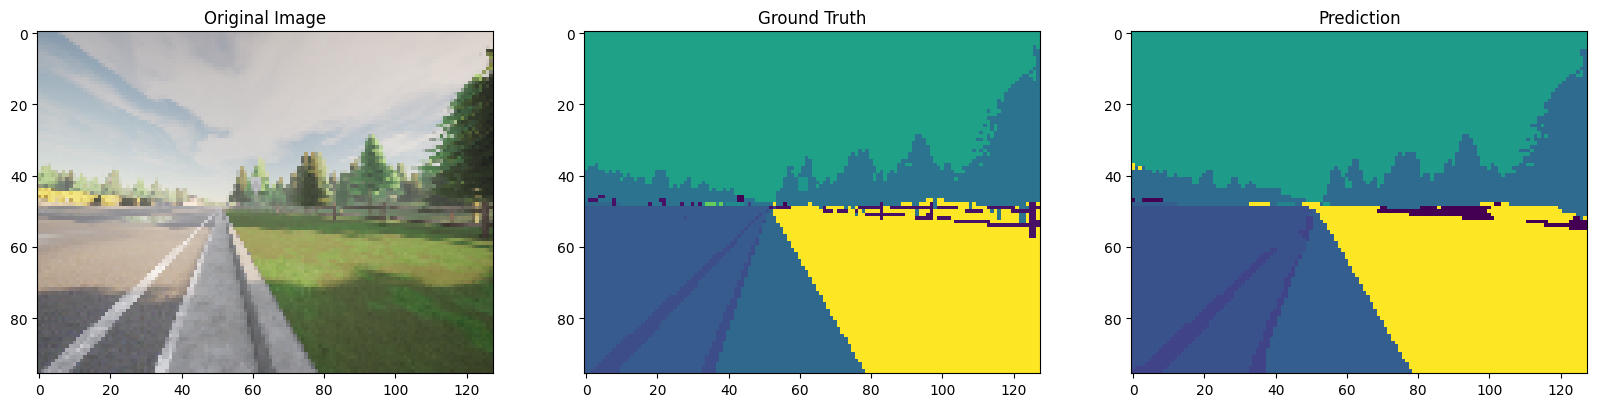

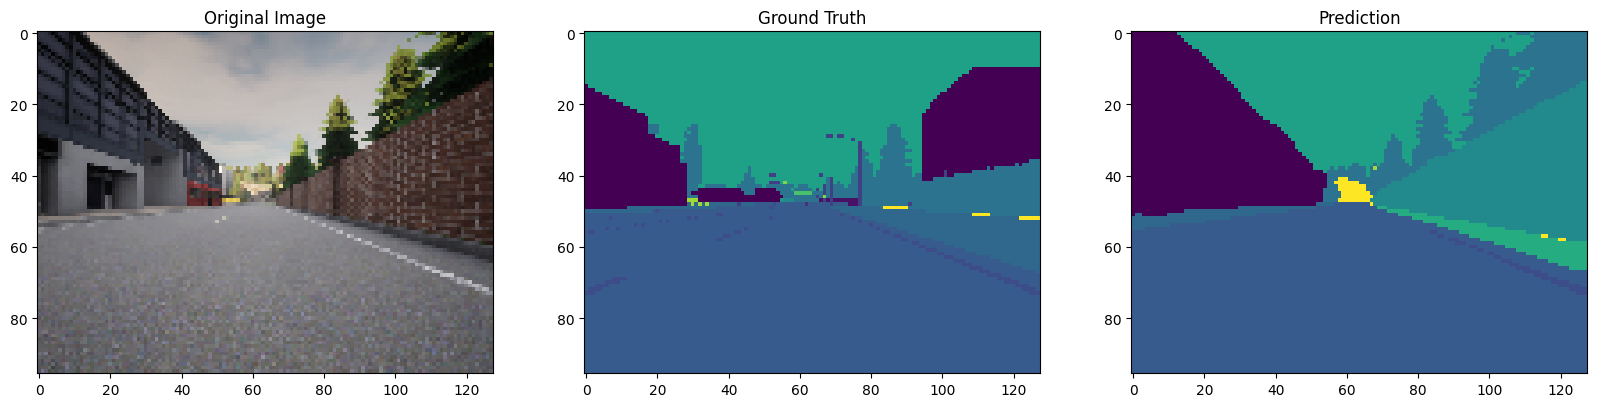

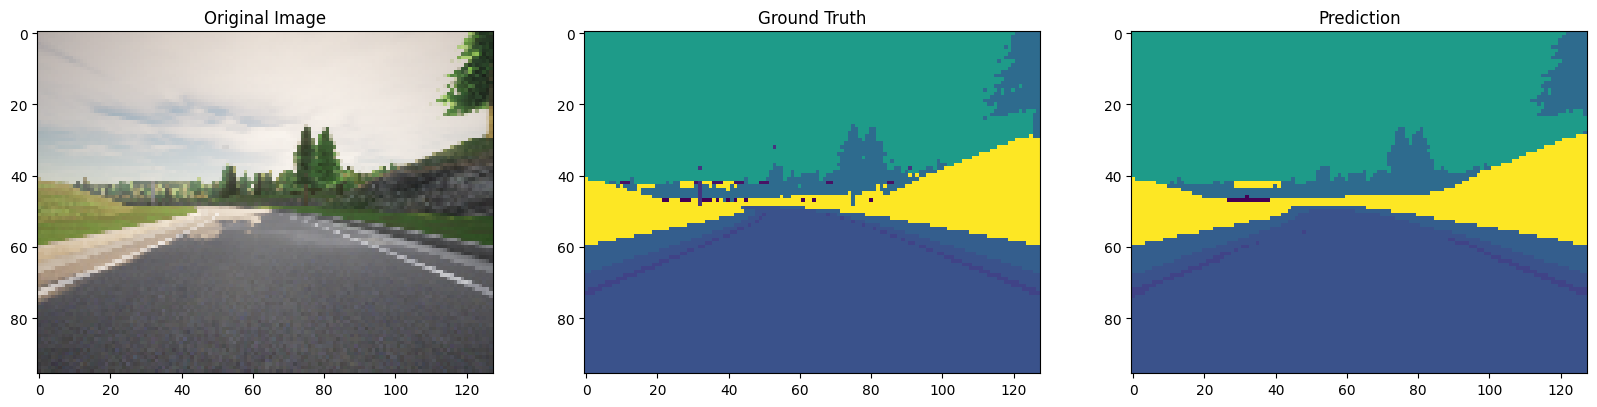

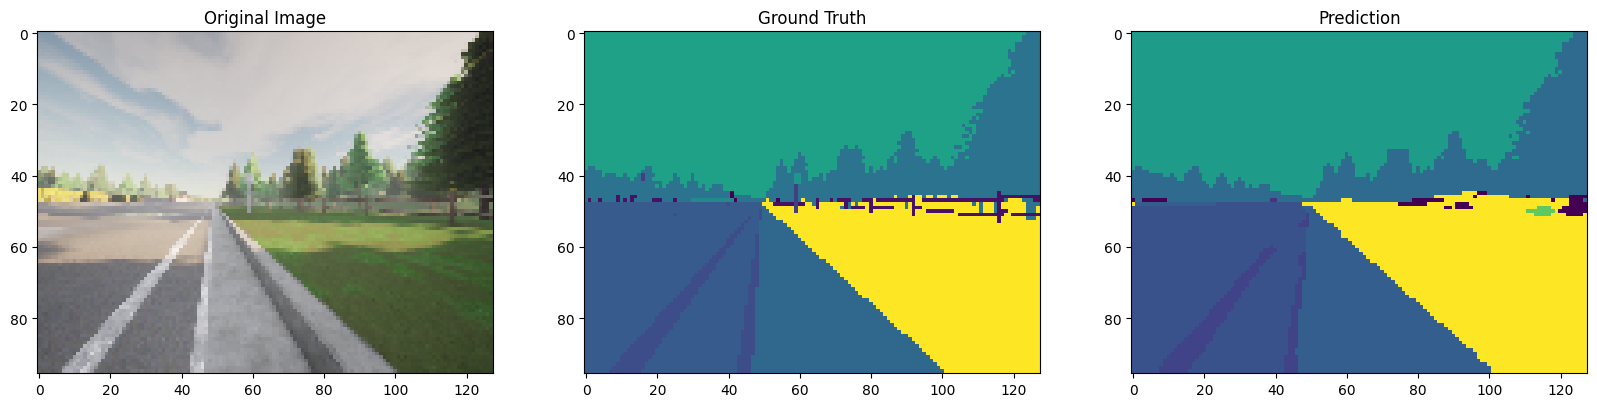

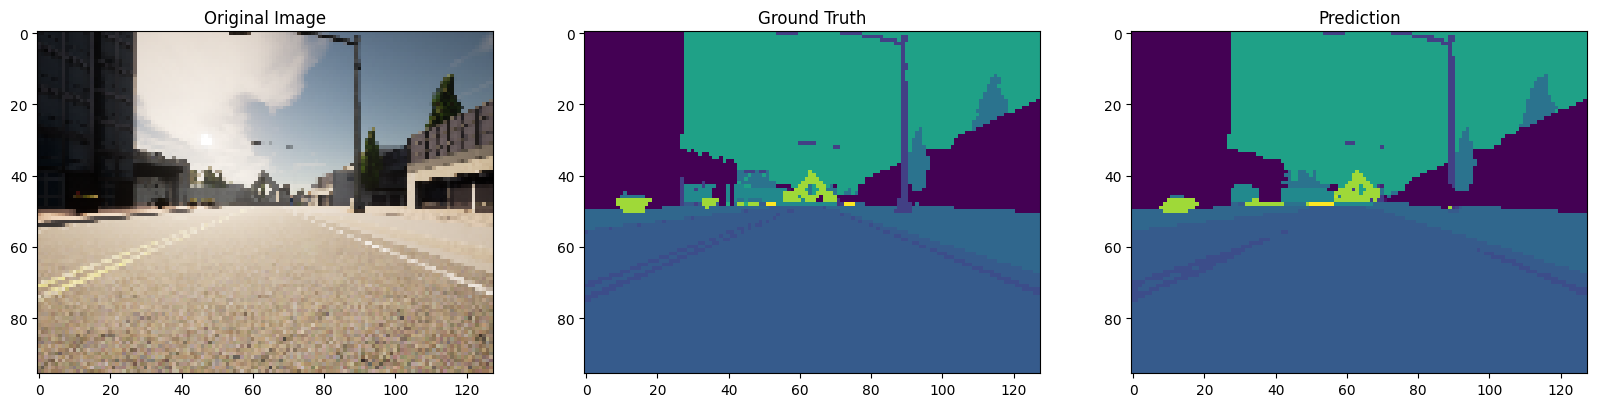

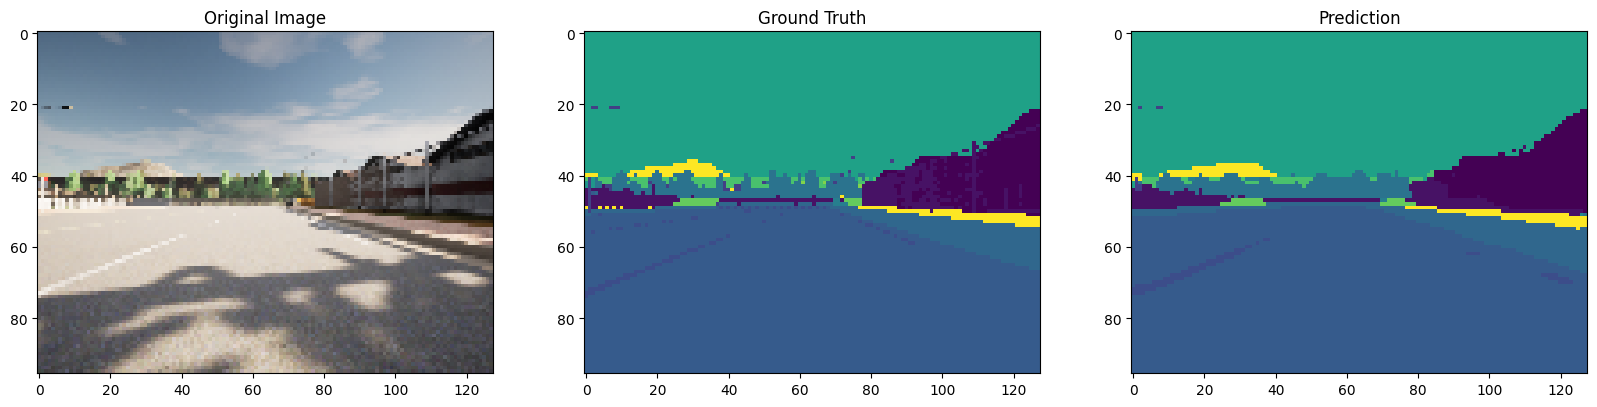

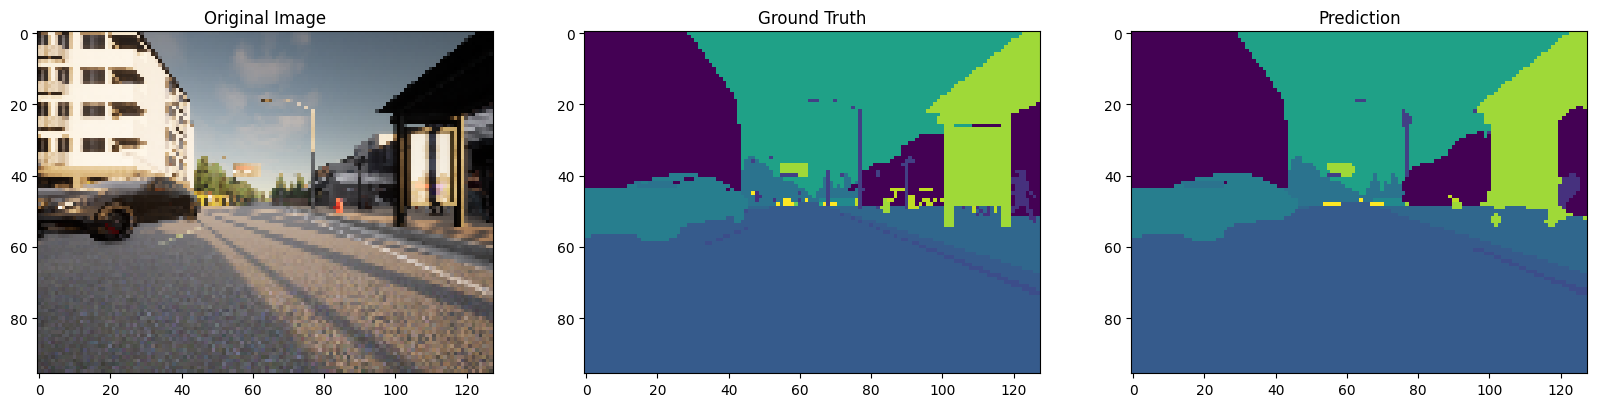

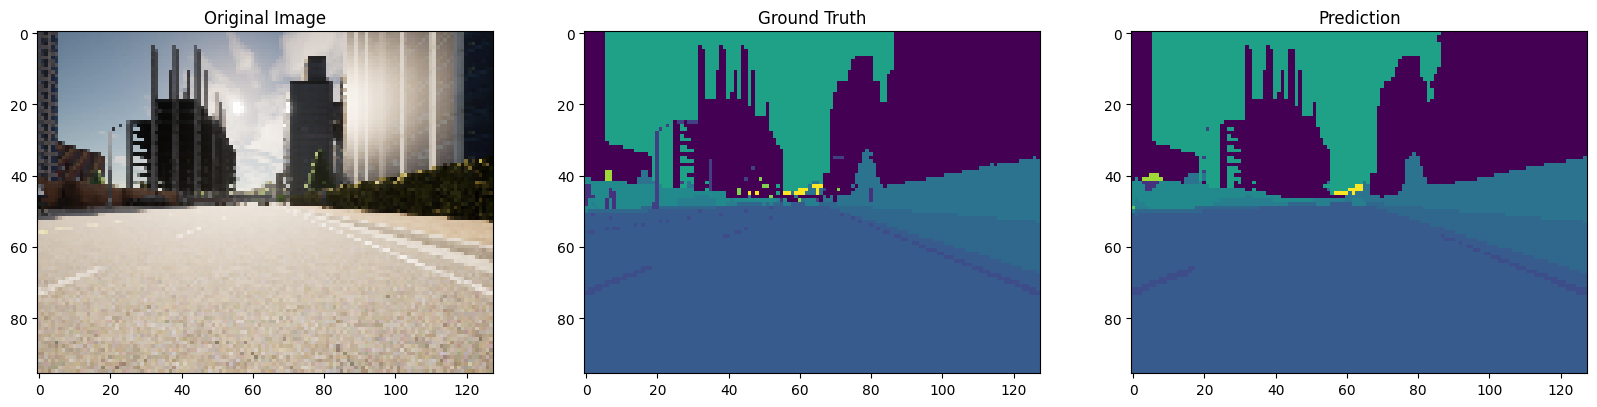

In [18]:
test_iter = iter(testloader)
images, masks = next(test_iter)

model.eval()
preds = model(images.to(DEVICE))
preds = torch.argmax(preds, dim = 1, keepdim = True)

for i, image in enumerate(images):
    fig, ax = plt.subplots(1, 3, figsize = (20, 20))
    ax[0].imshow(image.permute(1,2,0))
    ax[0].set_title('Original Image')
    ax[1].imshow(masks[i])
    ax[1].set_title('Ground Truth')
    ax[2].imshow(preds[i].permute(1,2,0).detach().cpu().numpy())
    ax[2].set_title('Prediction')